<h3>Import necessary libararies

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

import pickle

import itertools
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [37]:
import warnings

warnings.filterwarnings('ignore')

## Since we were unable to effectively evaluate the self-classification of the Y variable, we will attempt to assess the classification using supervised learning in order to appraise the overall fit and for each cluster specifically, whether the title corresponds to the article's description


---



<h3>Load in clean_dfgnews_cluster_title

In [38]:
url = 'https://raw.githubusercontent.com/aviya-gmara/News-Classification-Project-/main/clean_dfgnews_cluster_title.csv'

clean_dfgnews_cluster_title = pd.read_csv(url)

In [39]:
clean_dfgnews_cluster_title.shape

(7004, 16)

In [40]:
clean_dfgnews_cluster_title = clean_dfgnews_cluster_title.drop(['Unnamed: 0'], axis = 1)

In [41]:
clean_dfgnews_cluster_title.head()

,title,description,content,url,publishedAt,len_content_article,len_description_article,first_250_words,sent_word_tokenized_first_250_no_stops,stemmed,lemmatized_text,clean_text_feature,Bigrams,initial_cluster,cluster_title
0,A San Fernando Valley athlete will be represen...,Israel Mateos says frontball isn't typically p...,Israel Mateos is representing Team USA at this...,https://abc7.com/israel-mateos-frontball-pan-a...,2023-10-06 00:11:11+00:00,266,97,israel mateos says frontball isn't typically p...,"['israel', 'mateos', 'says', 'frontball', 'isn...",israel mateo say frontbal isnt typic play us p...,mateo frontbal isnt typic play plan chang,mateo frontbal isnt typic play plan chang,mateo_frontbal frontbal_isnt isnt_typic typic_...,9,Social Unrest and Political Support
1,Palestinian gunmen reported in Israel as barra...,Palestinian gunmen reported in Israel as barra...,"Published Oct 07, 2023 12:49AM ET Updated Oct ...",https://www.investing.com/news/world-news/rock...,2023-10-06 04:00:00+00:00,266,68,palestinian gunmen reported in israel as barra...,"['palestinian', 'gunmen', 'reported', 'israel'...",palestinian gunmen report israel barrag launch...,palestinian gunman report barrag launch,palestinian gunman report barrag launch,palestinian_gunman gunman_report report_barrag...,9,Social Unrest and Political Support
2,Conflict between Israel and Palestinians in Gaza,Conflict between Israel and Palestinians in Gaza,"Published Oct 07, 2023 04:09AM ET\n© Reuters. ...",https://www.investing.com/news/world-news/conf...,2023-10-06 04:00:00+00:00,266,48,conflict between israel and palestinians in gaza,"['conflict', 'israel', 'palestinians', 'gaza']",conflict israel palestinian gaza,conflict palestinian,conflict palestinian,conflict_palestinian,14,Live Updates and Conflict Coverage
3,On This Day in History,"On Oct. 6, 1973, Egypt and Syria launched a co...",1 of 4 | Israeli soldiers lay flowers at a war...,https://www.upi.com/Top_News/2023/10/06/UPI-Al...,2023-10-06 07:00:07+00:00,266,175,"on oct. 6, 1973, egypt and syria launched a co...","['oct', '6', '1973', 'egypt', 'syria', 'launch...",oct 6 1973 egypt syria launch coordin attack i...,oct 6 1973 egypt syria launch coordin attack y...,october 6 1973 egypt syria launch coordin atta...,october_6 6_1973 1973_egypt egypt_syria syria_...,9,Social Unrest and Political Support
4,US tourist arrested for smashing Roman statues...,Israeli police have arrested an American touri...,Israeli police have arrested an American touri...,https://www.nbcboston.com/news/national-intern...,2023-10-06 08:31:41+00:00,266,162,israeli police have arrested an american touri...,"['israeli', 'police', 'arrested', 'american', ...",isra polic arrest american tourist israel muse...,polic arrest american tourist museum jerusalem...,polic arrest american tourist museum jerusalem...,polic_arrest arrest_american american_tourist ...,9,Social Unrest and Political Support


<h3>Check for null values

In [42]:
clean_dfgnews_cluster_title.isnull().sum()

title                                     0
description                               0
content                                   0
url                                       0
publishedAt                               0
len_content_article                       0
len_description_article                   0
first_250_words                           0
sent_word_tokenized_first_250_no_stops    0
stemmed                                   0
lemmatized_text                           0
clean_text_feature                        0
Bigrams                                   2
initial_cluster                           0
cluster_title                             0
dtype: int64

In [43]:
clean_dfgnews_cluster_title = clean_dfgnews_cluster_title.dropna(subset = ['Bigrams'])

In [44]:
clean_dfgnews_cluster_title.shape

(7002, 15)

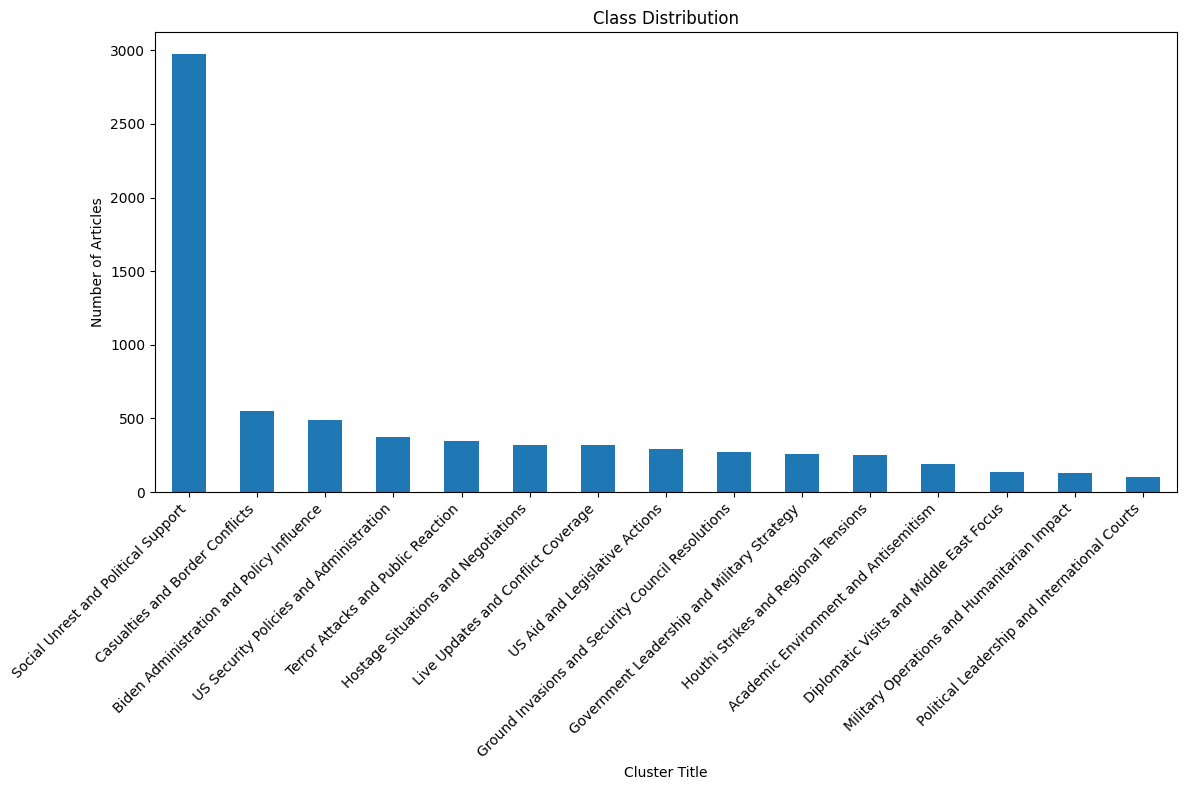

In [45]:
# This assumes `cluster_title` contains the names of the clusters.
class_distribution = clean_dfgnews_cluster_title['cluster_title'].value_counts()

plt.figure(figsize=(12,8))
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Cluster Title')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')  # Rotate the cluster titles for better readability
plt.tight_layout()  # Adjust layout to fit cluster titles
plt.show()


### plot_classification_results

In [46]:
def plot_classification_results(y_true, y_pred, df, actual_label_col, title_col):
    """
    This function plots a confusion matrix with labels.

    Parameters:
    y_true: Actual labels
    y_pred: Predicted labels
    df: DataFrame that contains the cluster titles and their corresponding encoded labels
    actual_label_col: The name of the column in df that contains the encoded labels
    title_col: The name of the column in df that contains the cluster titles
    """
    # Generate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Create a mapping from actual labels to titles
    label_to_title_map = df.drop_duplicates(subset=actual_label_col).set_index(actual_label_col)[title_col].to_dict()

    # Sort the cluster titles according to the order of unique labels in y_true
    sorted_titles = [label_to_title_map[label] for label in sorted(np.unique(y_true))]

    # Plotting the heatmap for confusion matrix
    plt.figure(figsize=(12,10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=sorted_titles, yticklabels=sorted_titles)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Cluster Title')
    plt.xlabel('Predicted Cluster Title')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


### function plots F1-Score Bar Chart and Classification Report Heatmap

In [47]:
def model_performance_visualization(y_test, y_pred, class_labels, model_name):
    """
    This function plots F1-Score Bar Chart and Classification Report Heatmap for the provided
    true and predicted labels, including the model name in the titles.

    Parameters:
    y_test: True labels (1-dimensional array)
    y_pred: Predicted labels (1-dimensional array)
    class_labels: List of unique class labels
    model_name: Name of the model used for classification
    """

    # Plot F1-Score bar chart
    plt.figure(figsize=(12, 6))
    f1_scores = f1_score(y_test, y_pred, average=None)
    plt.bar(range(len(class_labels)), f1_scores, color='skyblue', align='center')
    plt.xticks(range(len(class_labels)), class_labels, rotation=90)
    plt.xlabel('Classes')
    plt.ylabel('F1 Score')
    plt.title(f'F1 Scores by Class - {model_name}')
    plt.tight_layout()  # Adjust layout to fit class labels
    plt.show()

    # Plot Classification Report Heatmap
    report = classification_report(y_test, y_pred, target_names=class_labels, output_dict=True)
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='coolwarm')
    plt.title(f'Classification Report Heatmap - {model_name}')
    plt.show()

In [48]:
class_labels = clean_dfgnews_cluster_title['cluster_title'].unique().tolist()


In [49]:
clean_dfgnews_cluster_title['cluster_title'].value_counts()

Social Unrest and Political Support                  2974
Casualties and Border Conflicts                       548
Biden Administration and Policy Influence             490
US Security Policies and Administration               377
Terror Attacks and Public Reaction                    348
Hostage Situations and Negotiations                   320
Live Updates and Conflict Coverage                    316
US Aid and Legislative Actions                        294
Ground Invasions and Security Council Resolutions     270
Government Leadership and Military Strategy           259
Houthi Strikes and Regional Tensions                  249
Academic Environment and Antisemitism                 190
Diplomatic Visits and Middle East Focus               136
Military Operations and Humanitarian Impact           130
Political Leadership and International Courts         101
Name: cluster_title, dtype: int64

Since our data is not balanced we will also have to verify the F1 Score of each cluster


---



## Model Evaluation Strategy

To validate the effectiveness of our classification, we will assess three different models, aiming to achieve not only high-quality results but also to check for consistency across the models:

1. **Logistic Regression Classifier**: This model is a top performer, especially favored for its efficiency and interpretability in binary classification tasks.

2. **XGBoost Classifier**: Renowned for its speed and model performance, XGBoost is particularly strong in structured data classification challenges.

3. **Bag of Words with Keras Neural Network**: Utilizing a deep learning framework, this model is well-suited for text data, capable of capturing complex patterns within the large feature space that is typical in natural language processing tasks.

### Why These Models?

Each selected model has distinct advantages for the task at hand:

- The **Logistic Regression Classifier** serves as a strong baseline, handling linear relationships between features and the target variable effectively.

- The **XGBoost Classifier** excels in capturing non-linearities and interactions between features, offering feature importance scores that provide insight into the predictive power of each attribute.

- The **Bag of Words with Keras Neural Network** is adept at processing text data, taking into account the order and structure within text to identify relevant patterns that aid classification.

By leveraging the strengths of these diverse models, we aim to robustly classify article descriptions against their corresponding titles or categories, providing a comprehensive overview of their suitability for our dataset.


###Train Test Split

In [50]:
X = clean_dfgnews_cluster_title.description
y = clean_dfgnews_cluster_title.initial_cluster

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

<h3>Logistic Regression Classifier  -- TOP PERFORMER

In [51]:
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=100000.0, n_jobs=1))])

In [52]:
%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.8715203426124197
              precision    recall  f1-score   support

           0       0.83      0.80      0.82        25
           1       1.00      1.00      1.00        19
           2       0.94      0.89      0.91        53
           3       0.84      0.81      0.83       106
           4       0.96      0.76      0.85        66
           5       0.91      0.89      0.90        54
           6       1.00      0.96      0.98        26
           7       0.91      0.94      0.93        33
           8       0.79      0.77      0.78        64
           9       0.89      0.92      0.90       607
          10       0.83      0.98      0.90        45
          11       0.80      0.79      0.79       109
          12       0.84      0.84      0.84        58
          13       0.83      0.79      0.81        72
          14       0.84      0.83      0.83        64

    accuracy                           0.87      1401
   macro avg       0.88      0.86      0.87      140

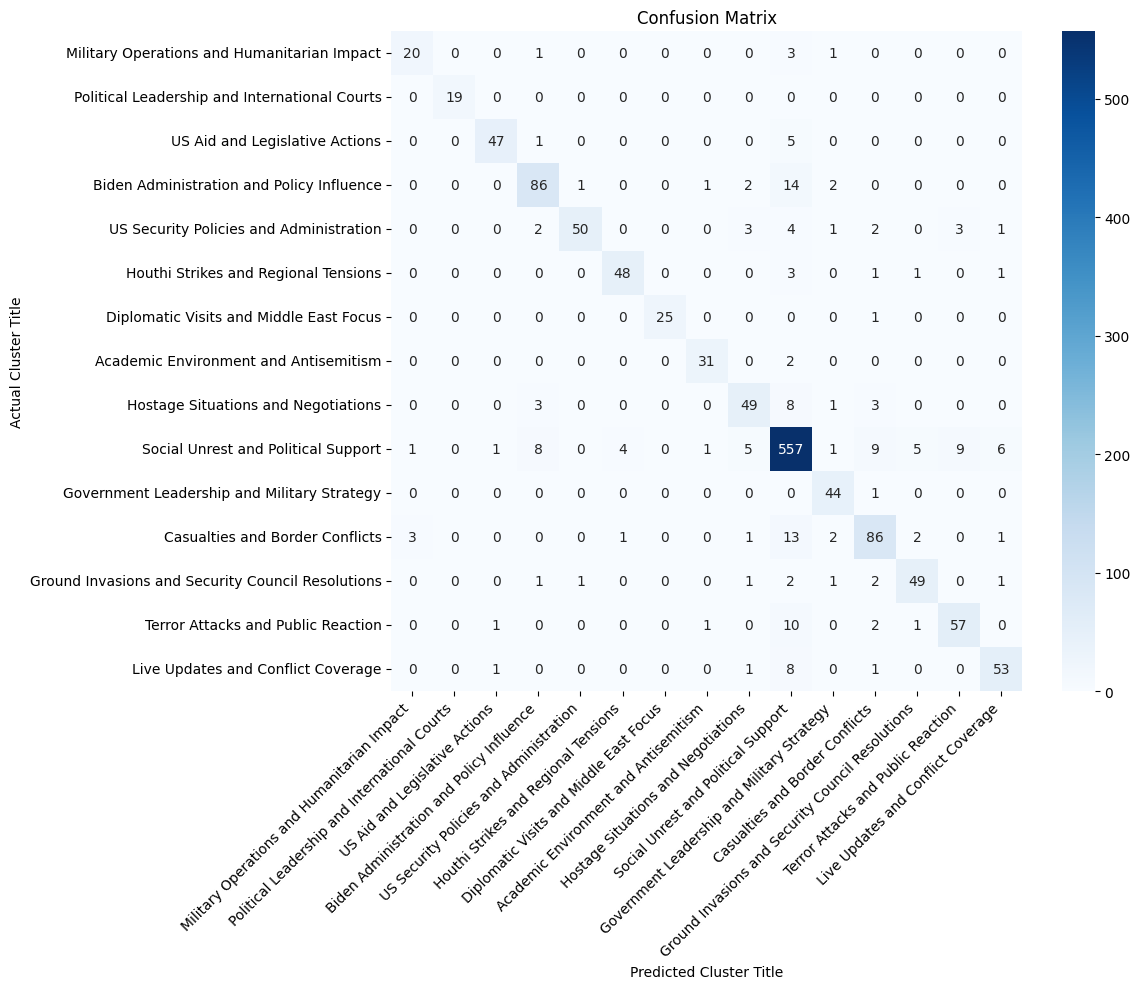

In [53]:
plot_classification_results(y_test, y_pred, clean_dfgnews_cluster_title, 'initial_cluster', 'cluster_title')

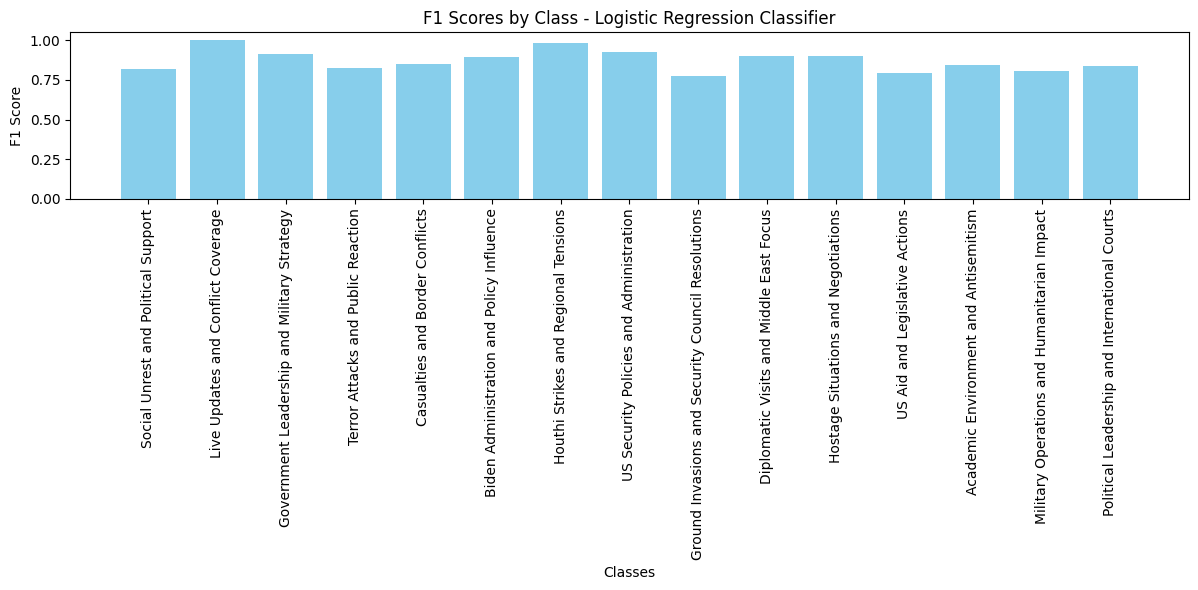

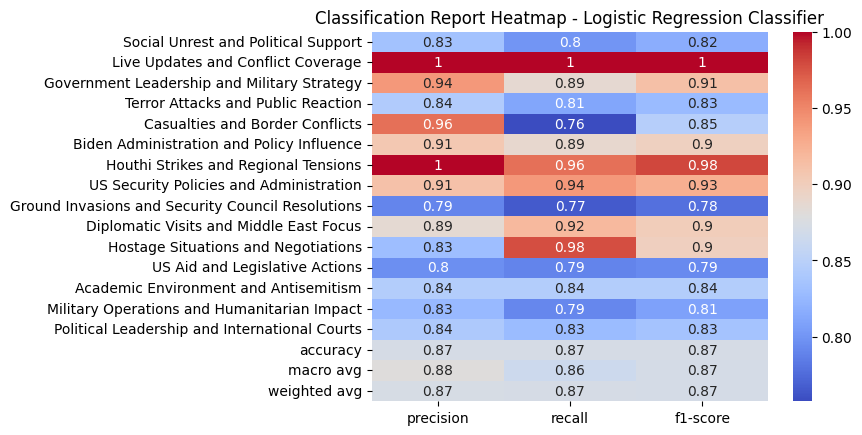

In [54]:
model_performance_visualization(y_test, y_pred, class_labels, "Logistic Regression Classifier")

<h3>XG Boost Classifier

In [55]:
xgb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', XGBClassifier()),
              ])
xgb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [56]:
%%time

y_pred = xgb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.8586723768736617
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        25
           1       0.90      1.00      0.95        19
           2       0.96      0.83      0.89        53
           3       0.83      0.85      0.84       106
           4       0.85      0.92      0.88        66
           5       0.93      0.70      0.80        54
           6       0.96      0.96      0.96        26
           7       0.82      0.85      0.84        33
           8       0.75      0.72      0.74        64
           9       0.88      0.91      0.89       607
          10       0.90      0.98      0.94        45
          11       0.81      0.80      0.81       109
          12       0.90      0.81      0.85        58
          13       0.85      0.72      0.78        72
          14       0.74      0.80      0.77        64

    accuracy                           0.86      1401
   macro avg       0.86      0.84      0.85      140

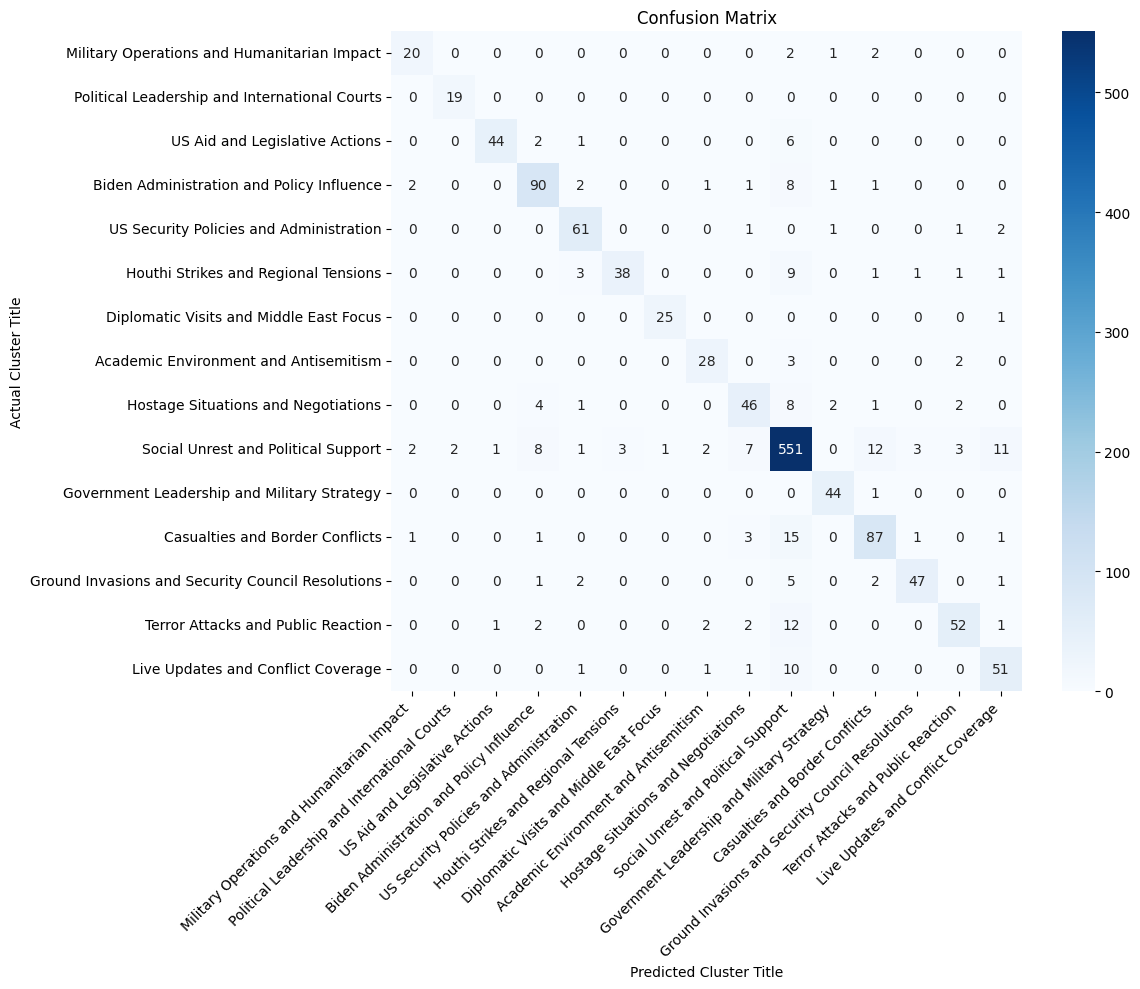

In [57]:
plot_classification_results(y_test, y_pred, clean_dfgnews_cluster_title, 'initial_cluster', 'cluster_title')


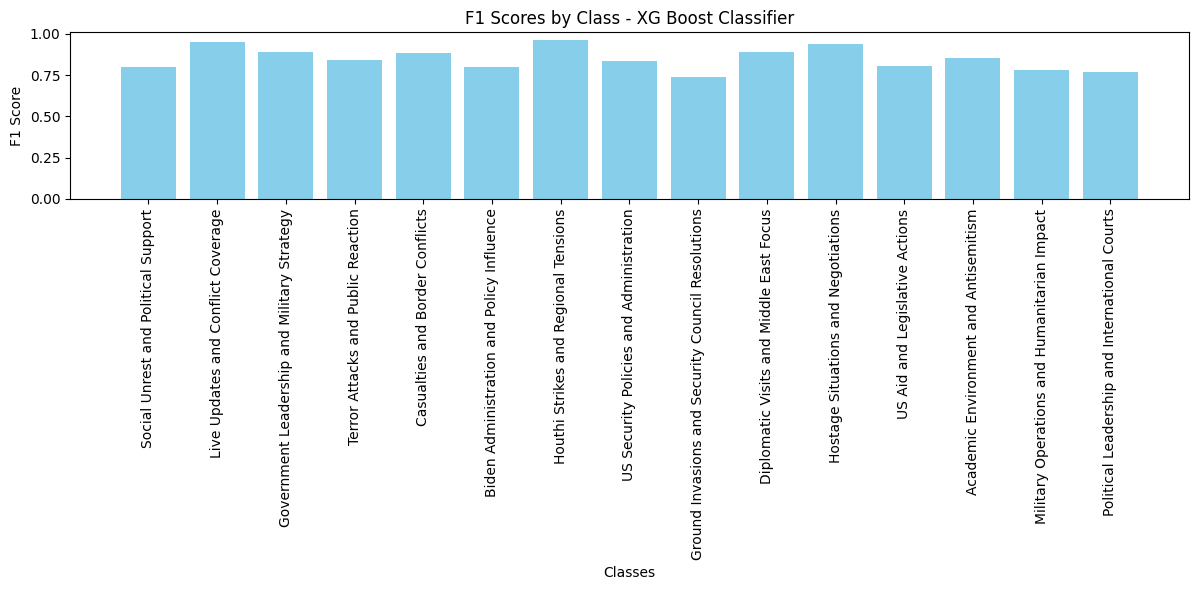

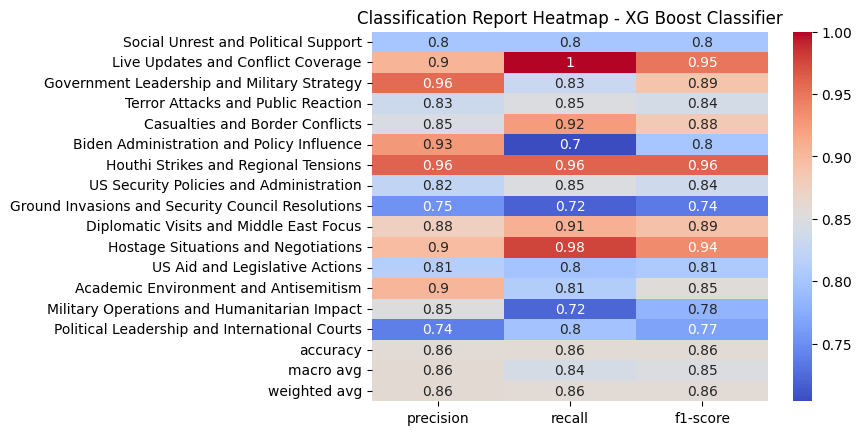

In [58]:
model_performance_visualization(y_test, y_pred, class_labels, "XG Boost Classifier")

<h3>BAG OF WORDS KERAS NEURAL NETWORK

In [59]:
#train test split
X = clean_dfgnews_cluster_title.description
y = clean_dfgnews_cluster_title.initial_cluster

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 40)

In [60]:
#tokenize the unique words in the vocab
max_words = 1000

#limit the vocab to the top words (max_words)
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

#creates a word index lookup of the vocab
tokenize.fit_on_texts(X_train) # only fit on train

In [61]:
#create matrix to pass into the neural network
x_train = tokenize.texts_to_matrix(X_train)
x_test = tokenize.texts_to_matrix(X_test)

In [62]:
#encode labels and fit to training
encoder = LabelEncoder()
encoder.fit(y_train)

#transform labels
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [63]:
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [64]:
batch_size = 32
epochs = 10

In [65]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [66]:
#set optimizer and loss, test for accuracy
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [67]:
#run the model
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/10
158/158 [==============================] - 3s 10ms/step - loss: 1.5490 - accuracy: 0.5613 - val_loss: 0.8366 - val_accuracy: 0.7308
Epoch 2/10
158/158 [==============================] - 2s 12ms/step - loss: 0.5469 - accuracy: 0.8343 - val_loss: 0.5142 - val_accuracy: 0.8485
Epoch 3/10
158/158 [==============================] - 2s 12ms/step - loss: 0.3212 - accuracy: 0.9060 - val_loss: 0.4625 - val_accuracy: 0.8449
Epoch 4/10
158/158 [==============================] - 1s 9ms/step - loss: 0.2165 - accuracy: 0.9413 - val_loss: 0.4265 - val_accuracy: 0.8627
Epoch 5/10
158/158 [==============================] - 1s 9ms/step - loss: 0.1546 - accuracy: 0.9611 - val_loss: 0.4272 - val_accuracy: 0.8663
Epoch 6/10
158/158 [==============================] - 2s 9ms/step - loss: 0.1132 - accuracy: 0.9748 - val_loss: 0.4244 - val_accuracy: 0.8699
Epoch 7/10
158/158 [==============================] - 2s 10ms/step - loss: 0.0881 - accuracy: 0.9810 - val_loss: 0.4257 - val_accuracy: 0.8681
Ep

In [68]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])
# print(classification_report(y_test, y_pred))

44/44 [==============================] - 0s 3ms/step - loss: 0.4941 - accuracy: 0.8544
Test accuracy: 0.8543897271156311


In [71]:
y_test_labels = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test

44/44 [==============================] - 0s 3ms/step


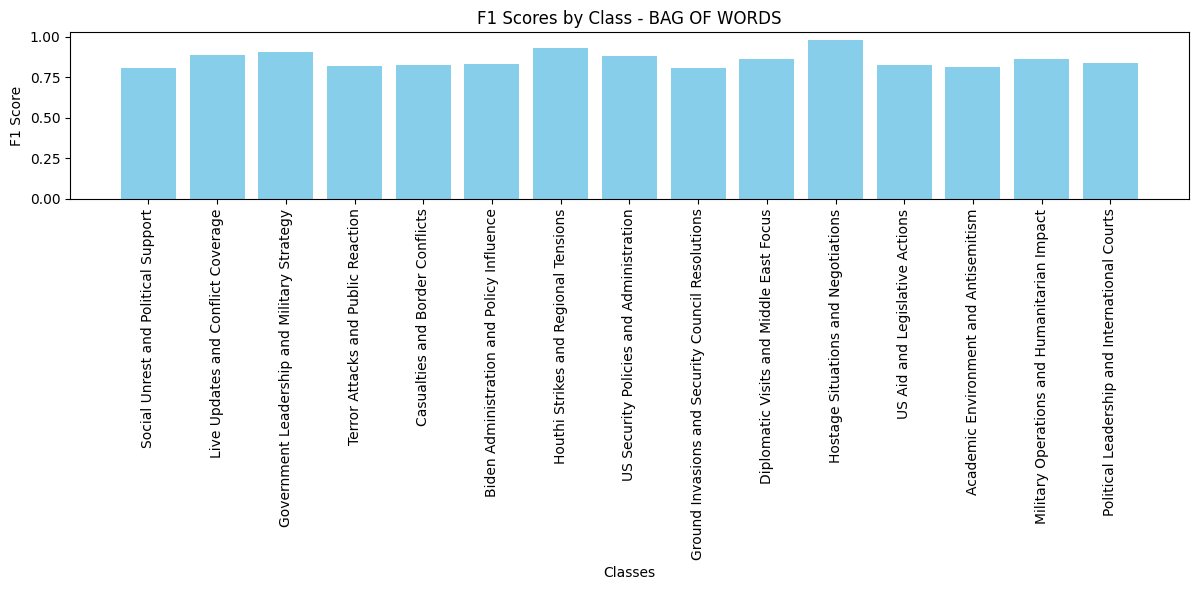

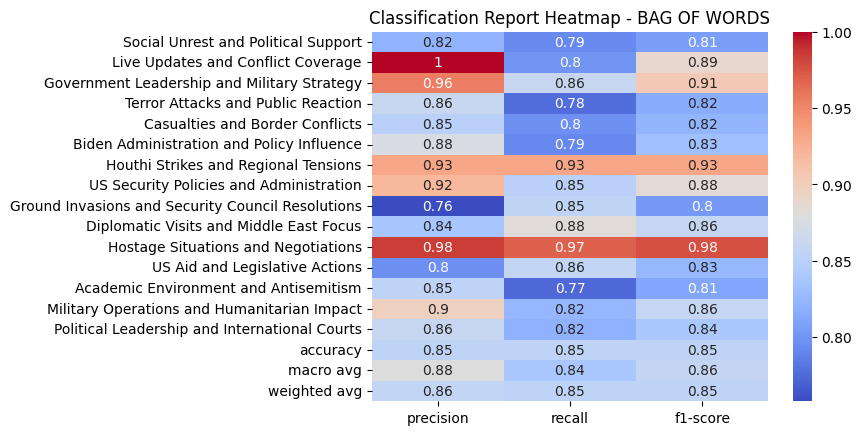

In [72]:
y_pred_prob = model.predict(x_test)  # This gives you the predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # This converts probabilities to class labels
model_performance_visualization(y_test_labels, y_pred, class_labels, "BAG OF WORDS")





---

# In summary - the F1 Scores ranged between 85% -87% in all models, which indicates that the classification works relatively well.
## **The Logistic Regression Classifier presented the best performance.**


##Initially, we approached the classification quality with a degree of skepticism. However, the consistent results across all models, coupled with their relative success despite the presence of a predominant cluster, suggest that the original classification was quite effective. The uniformity of good results across different models reinforces our confidence in the classification technique used. While further performance tuning and parameter optimization could be pursued, we find the current results to meet our satisfaction at this juncture.